## Model Assumptions
* Once Recovered can't be infected again. Recovered and Death cases are simply removed from population.
* An airplane carries 115 passengers on average
* Number of people getting into a country is estimated as 

$$incomingPeople=incomingRoutes \cdot log_{10}~countryPopulation \cdot 115$$

* Number of people getting out of a country is estimated as 

$$outgoingPeople=outgoingRoutes \cdot log_{10}~countryPopulation \cdot 115$$

     This will be fractured for each compartment (S, I, R)


#### Useful notes
* beta and gamma can be selected from rates determined from prior outbreaks, but they often vary for different outbreaks of the same disease
* __To estimate beta and gamma from data__: if beta=0.29/day, the time it takes to double the number of infected people is about 1/0.29 = 3.4 days, hence, beta=1/days it takes to double infections. Similarly, gamma=0.15 implies that is takes 1/0.15=6.7 days to recover/die, hence, gamma=1/days it takes to recover/die.


In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import networkx as nx
from datetime import datetime as dt, date, timedelta

%matplotlib inline

In [6]:
# Load Graph
g_data = json.load(open("data/graph_to_load_in_nx.json", "r"))
g = nx.DiGraph()
g.add_weighted_edges_from(g_data)
countries = list(g.nodes)

In [7]:
# Load country coordinates and attach to nodes
countries_coords = pd.read_csv("data/country_centroids_az8.csv")
countries_coords = countries_coords[['name', 'Longitude', 'Latitude']]
countries_coords.replace(["Macao", "Korea"], ["Macau", "South Korea"], inplace=True)
countries_coords.index = countries_coords.name
countries_coords.loc['France', 'Longitude'] = 2.2137
countries_coords.loc['France', 'Latitude'] = 46.2276
countries_coords = countries_coords[countries_coords.name.isin(countries)][['Longitude', 'Latitude']]
coords_dict = countries_coords.to_dict(orient='index')
nx.set_node_attributes(g, coords_dict)

In [8]:
# Load Population data and attach to nodes
countries_population_data = pd.read_csv("data/countries_population_data.csv", index_col=0)
for c in countries:
    pop = countries_population_data[countries_population_data['Country'] == c]['Pop 2018'].values[0]
    nx.set_node_attributes(g, {c: {'Population': pop}})
    

In [9]:
# Load and clean COVID-19 data
confirmed = pd.read_csv("data/time_series_covid19_confirmed_global.csv")
confirmed.loc[61, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
confirmed.loc[69, 'Country/Region'] = "Macau"  #Hong Kong as its own country
confirmed.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
confirmed = confirmed.groupby('Country/Region').sum()  #Group regions by country
confirmed = confirmed[confirmed.index.isin(countries)]
confirmed.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(confirmed.index.values.tolist())) == 0

recovered = pd.read_csv("data/time_series_covid19_recovered_global.csv")
recovered.loc[52, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
recovered.loc[60, 'Country/Region'] = "Macau"  #Hong Kong as its own country
recovered.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
recovered = recovered.groupby('Country/Region').sum()  #Group regions by country
recovered = recovered[recovered.index.isin(countries)]
recovered.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(recovered.index.values.tolist())) == 0

deaths = pd.read_csv("data/time_series_covid19_deaths_global.csv")
deaths.loc[61, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
deaths.loc[69, 'Country/Region'] = "Macau"  #Hong Kong as its own country
deaths.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
deaths = deaths.groupby('Country/Region').sum()  #Group regions by country
deaths = deaths[deaths.index.isin(countries)]
deaths.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(deaths.index.values.tolist())) == 0

np.testing.assert_array_equal(confirmed.index.values, recovered.index.values, deaths.index.values)


In [10]:
# Define function to estimate Beta and Gamma given COVID-19 data
def getEstimatedBetaGamma(country, initial_pop, confirmed, recovered, deaths, T, verbose=True):
       
        first_confirmed_case = confirmed[confirmed.index == country].iloc[0].ne(0).idxmax()
        country_confirmed = confirmed[confirmed.index == country].loc[country, first_confirmed_case:].values
        I_0 = country_confirmed[0]

        country_recovered = recovered[recovered.index == country].loc[country, first_confirmed_case:].values
        R_0 = country_recovered[0]

        country_deaths = deaths[deaths.index == country].loc[country, first_confirmed_case:].values
        
        if verbose:
            print("{}'s first confirmed cases date: {} with {} infected and {} recovered.".format(
                country, first_confirmed_case, I_0, R_0
            ))

        S = [ initial_pop ]
        I = [ I_0 ]
        R = [ R_0 ]
        for t in range(1, len(country_confirmed)-1):
            
            S_t = S[t-1] - (country_confirmed[t] + country_recovered[t] + country_deaths[t])
            S.append(S_t)
            I_t = country_confirmed[t]
            I.append(I_t)
            R_t = country_recovered[t] + country_deaths[t]
            R.append(R_t)


        confirmed_doubled_intervals = []
        for i0 in range(len(I)):
            for i1 in range(len(I)):
                if I[i1] >= I[i0]*2:
                    confirmed_doubled_intervals.append(i1 - i0)
                    break

        country_betas = np.array([1/n if n>0 else 0 for n in confirmed_doubled_intervals])
        #print(country_betas)
        if verbose:
            print("{}'s average beta: {}".format(country, country_betas.mean().round(5)))

        confirmed_to_recovered_or_died_intervals = []
        for i in range(len(country_confirmed)):
            infected = country_confirmed[i]
            for j in range(len(country_confirmed)):
                recovered = country_recovered[j]
                deaths = country_deaths[j]
                if (recovered+deaths) >= infected:
                    confirmed_to_recovered_or_died_intervals.append(j-i)
                    break

        country_gammas = np.array([1/n if n>0 else 0 for n in confirmed_to_recovered_or_died_intervals])
        if verbose:
            print("{}'s average gamma: {}".format(country, country_gammas.mean().round(5)))

        return country_betas.mean(), country_gammas.mean()

In [11]:
# Estimate beta and gamma for each country and attach to node

T = 350  # Simulation number of days 

affected_countries_population = 0

country_populations = nx.get_node_attributes(g, "Population")
for c in countries:
    affected_countries_population += country_populations[c]
    beta, gamma = getEstimatedBetaGamma(c, country_populations[c], confirmed, recovered, deaths, T, verbose=False)
    nx.set_node_attributes(g, {c: {"Beta": beta, 'Gamma': gamma}})

In [12]:
# Simulation
country_betas = nx.get_node_attributes(g, "Beta")
country_gammas = nx.get_node_attributes(g, "Gamma")

# Precompute outbound routes for each country
out_routes = {}
for country in countries:
    outgoing_routes = sum([g.get_edge_data(country, i)["weight"] for i in g.neighbors(country)])
    out_routes[country] = outgoing_routes

S_lists = {}
I_lists = {}
R_lists = {}

# Initialise lists values
for c in countries:
    S_lists[c] = [ country_populations[c] ]
    I_lists[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight'] 
                n_total_pop = S_lists[n][t-1] + I_lists[n][t-1] + R_lists[n][t-1]
                n_in_population = n_in_route * (np.log10(n_total_pop)/10) * 115
                S_in_t += (S_lists[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists[c][t-1] + I_lists[c][t-1] + R_lists[c][t-1]
        out_population = out_routes[c] * (np.log10(current_population)/10) * 115
        S_out_t = (S_lists[c][t-1] / current_population) * out_population
        I_out_t = (I_lists[c][t-1] / current_population) * out_population
        R_out_t = (R_lists[c][t-1] / current_population) * out_population

        S_t = S_lists[c][t-1] - ((S_lists[c][t-1] / S_lists[c][0]) * (country_betas[c]*I_lists[c][t-1]))
        S_lists[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists[c][t-1] + ((S_lists[c][t-1] / S_lists[c][0]) * (country_betas[c]*I_lists[c][t-1])) - (I_lists[c][t-1] * country_gammas[c])
        I_lists[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists[c][t-1] + (I_lists[c][t-1] * country_gammas[c])
        R_lists[c].append(R_t - R_out_t + R_in_t)
        
      

South Korea


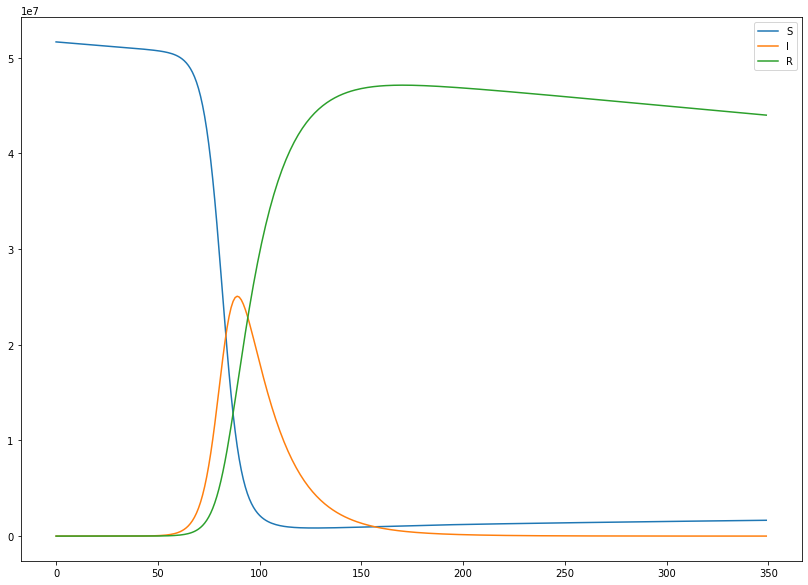

Israel


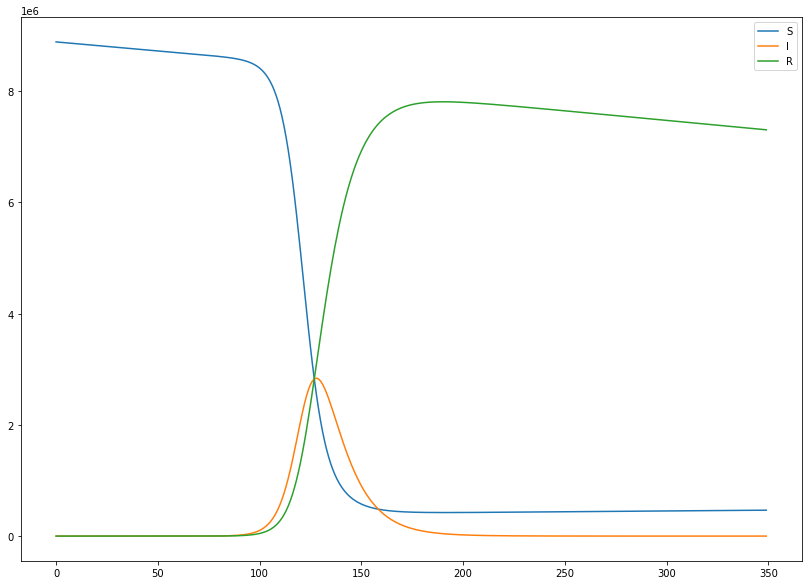

Philippines


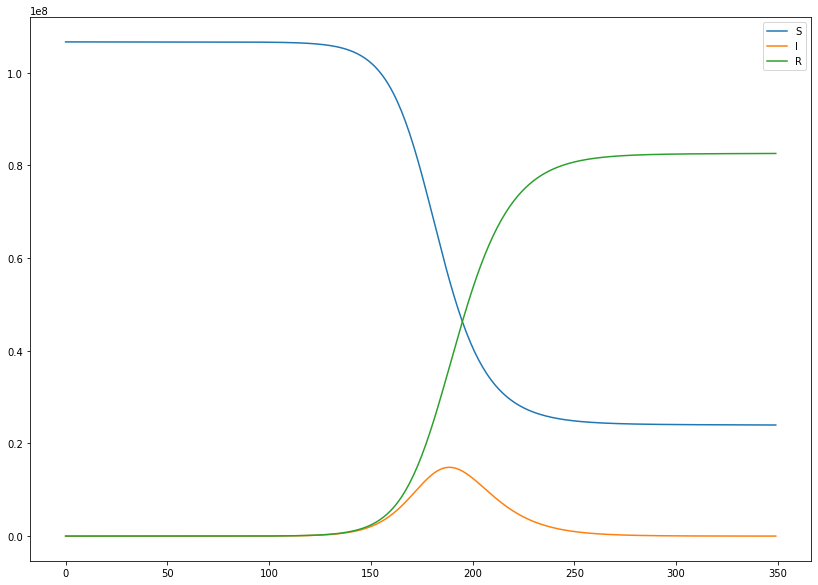

United States


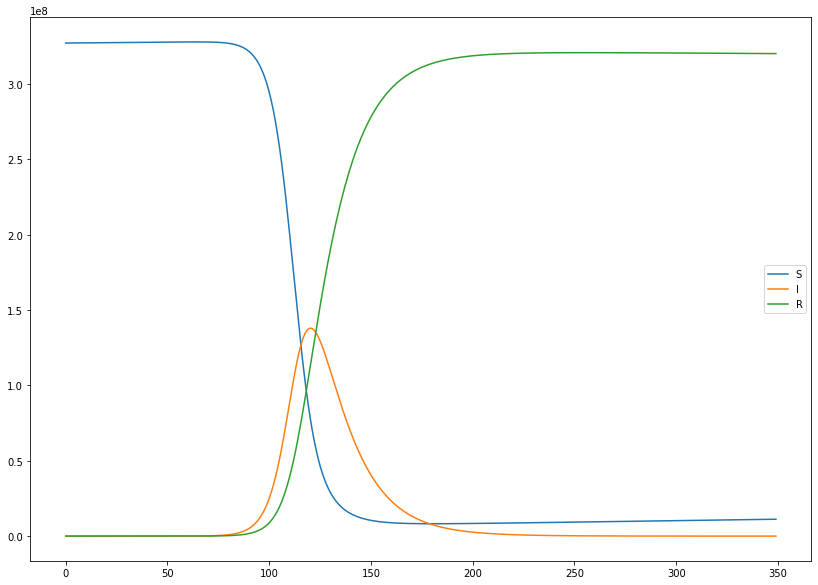

United Kingdom


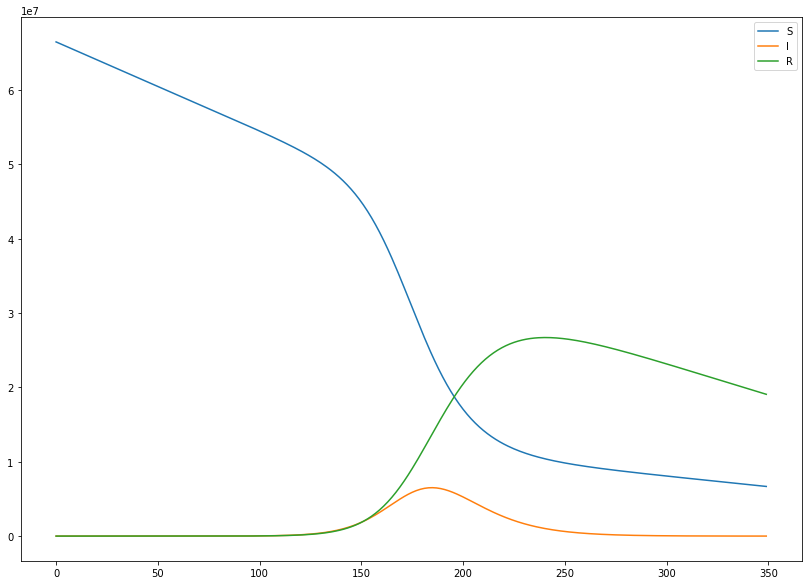

Singapore


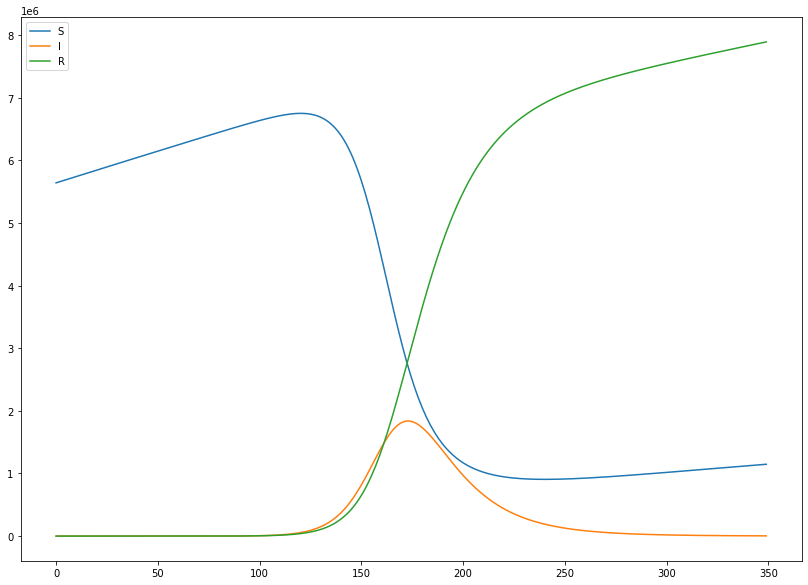

Sweden


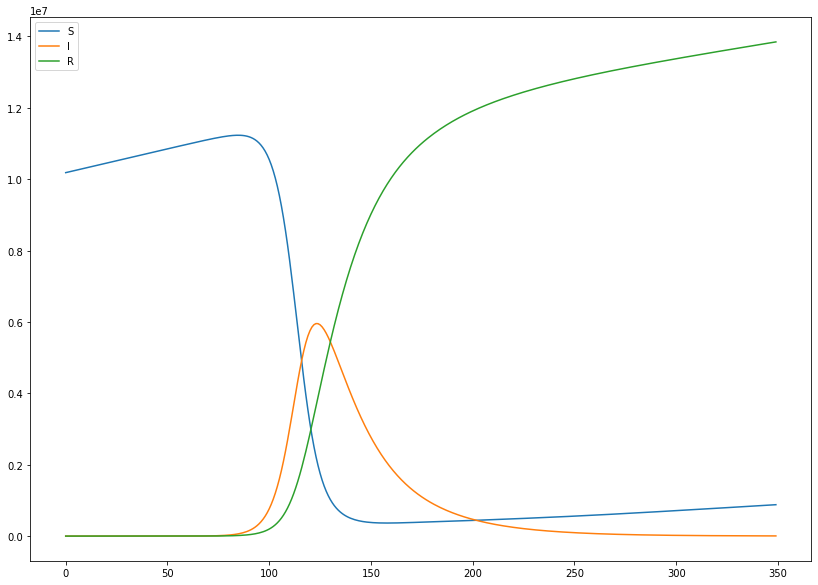

Italy


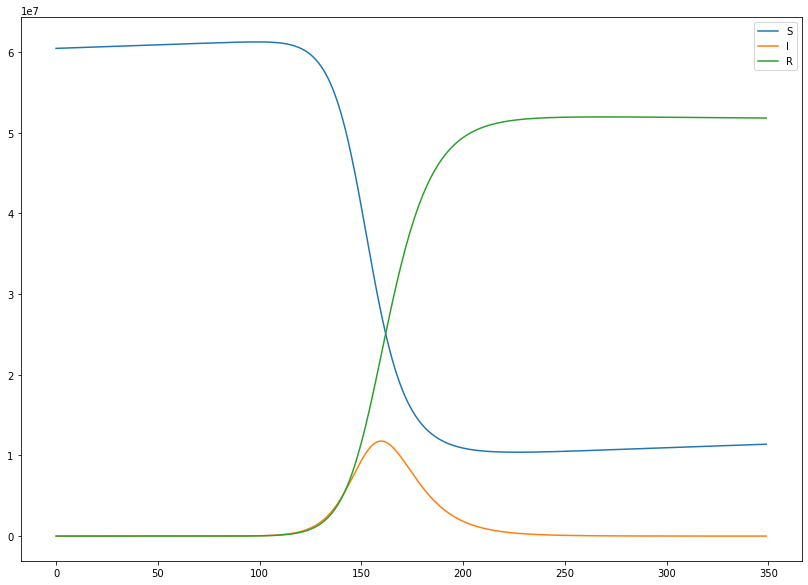

France


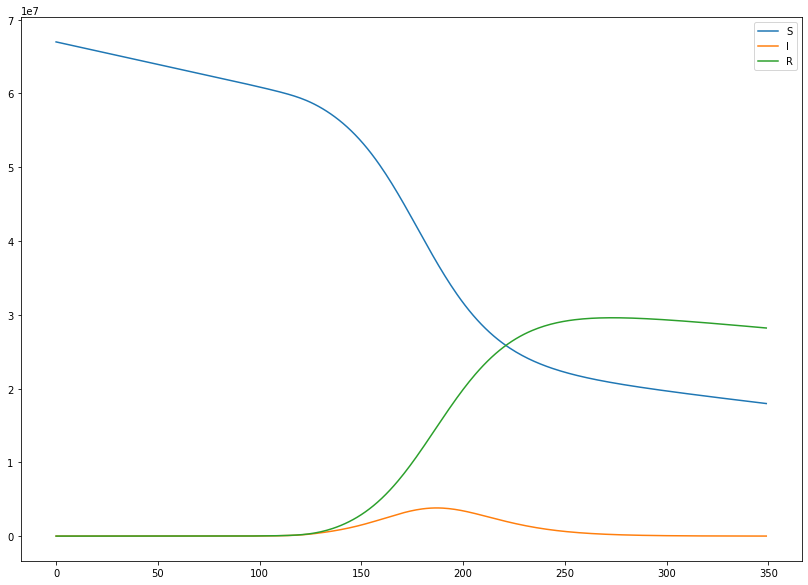

Finland


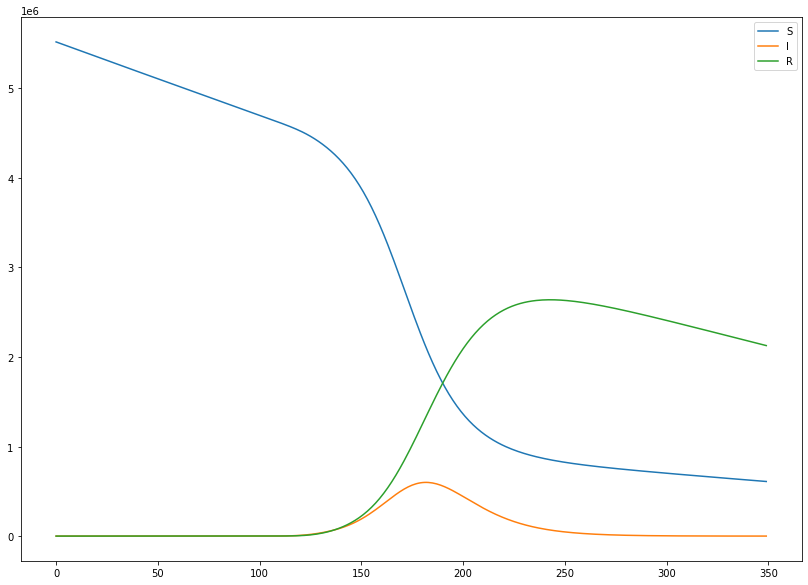

Vietnam


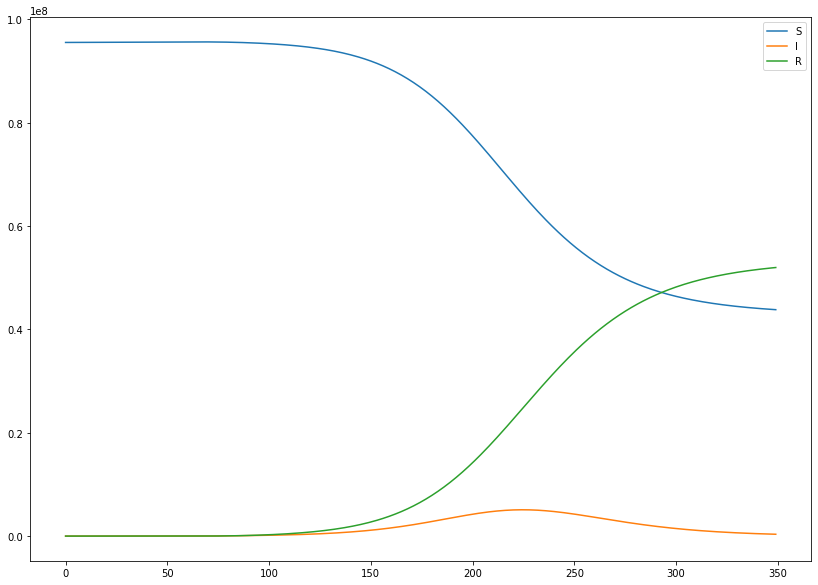

Russia


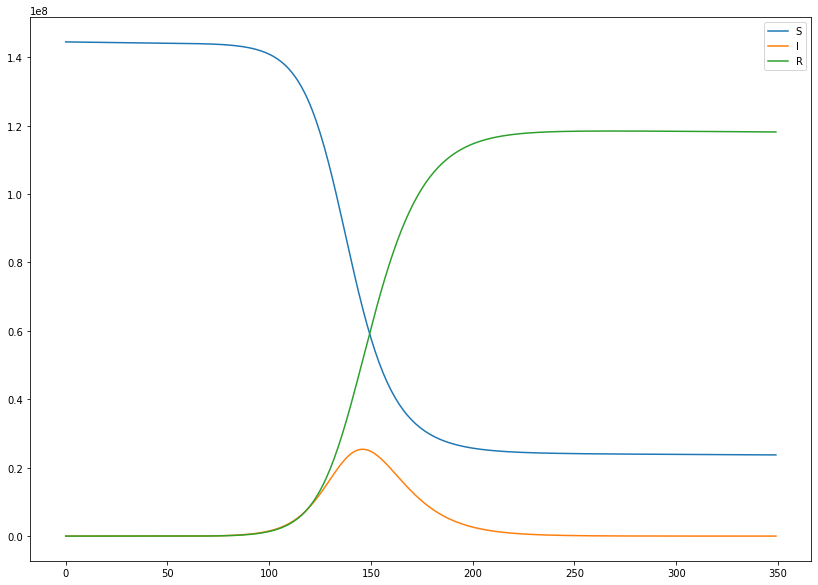

Macau


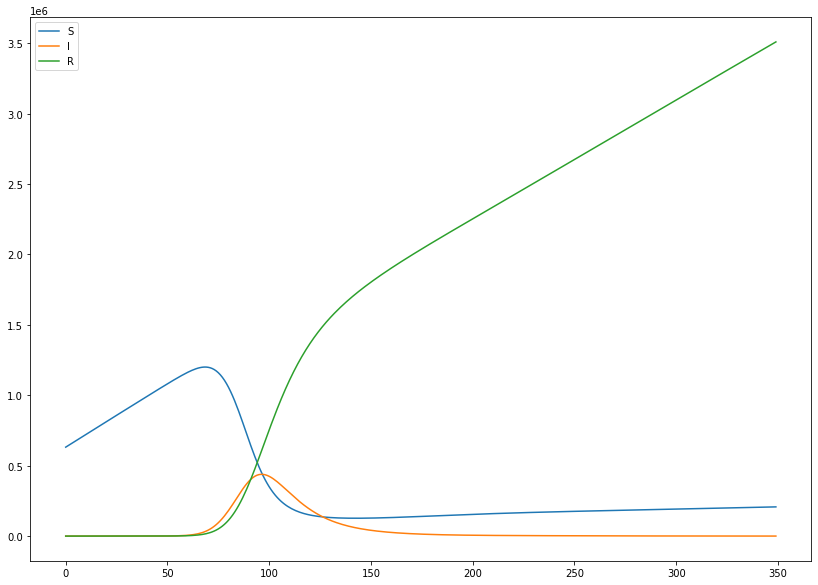

Taiwan


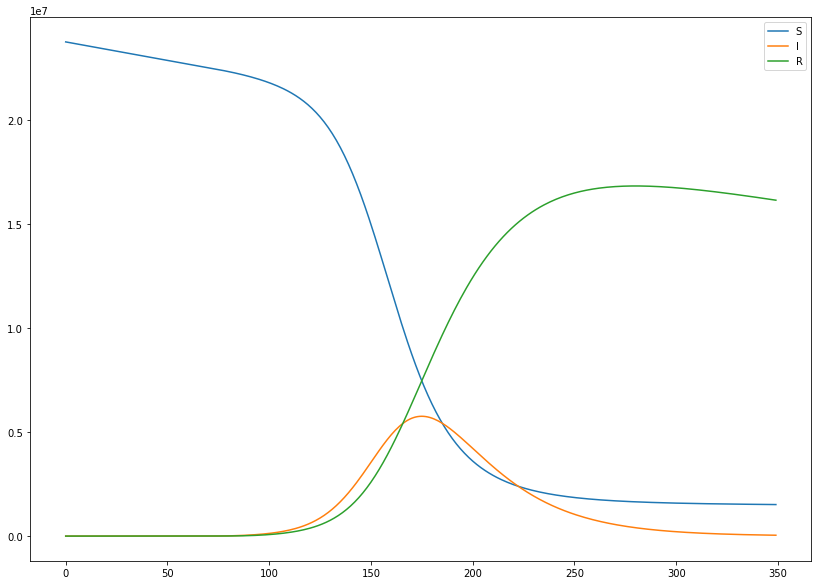

Japan


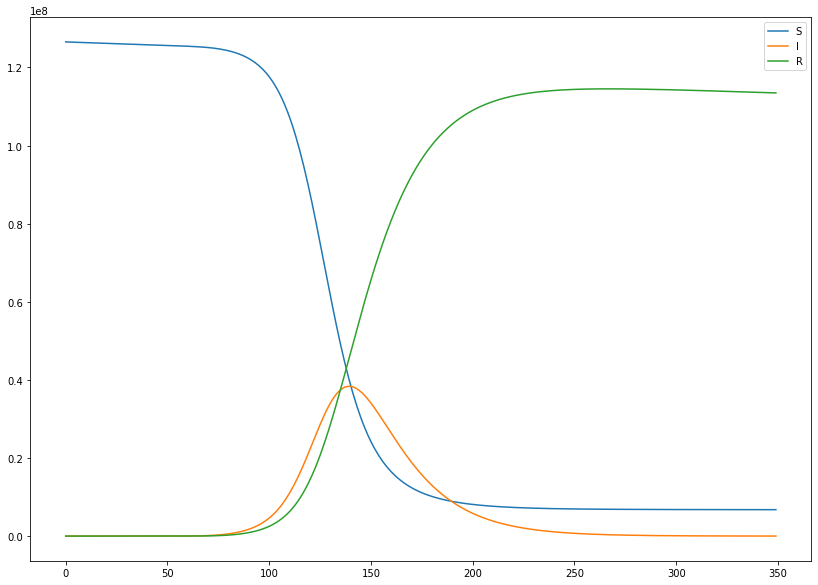

Malaysia


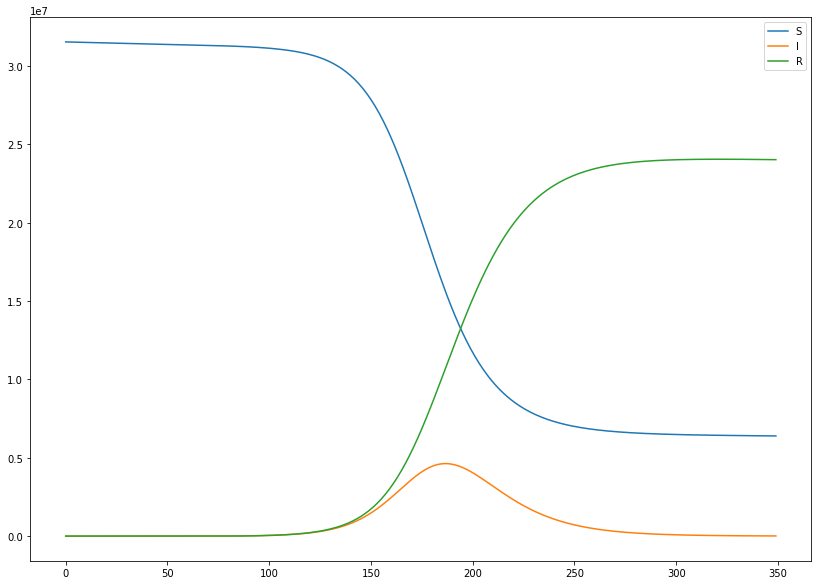

Thailand


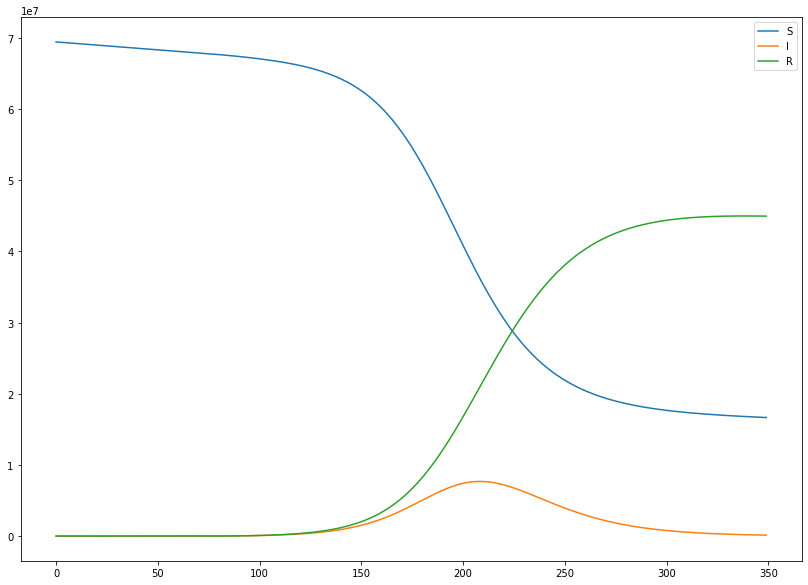

Germany


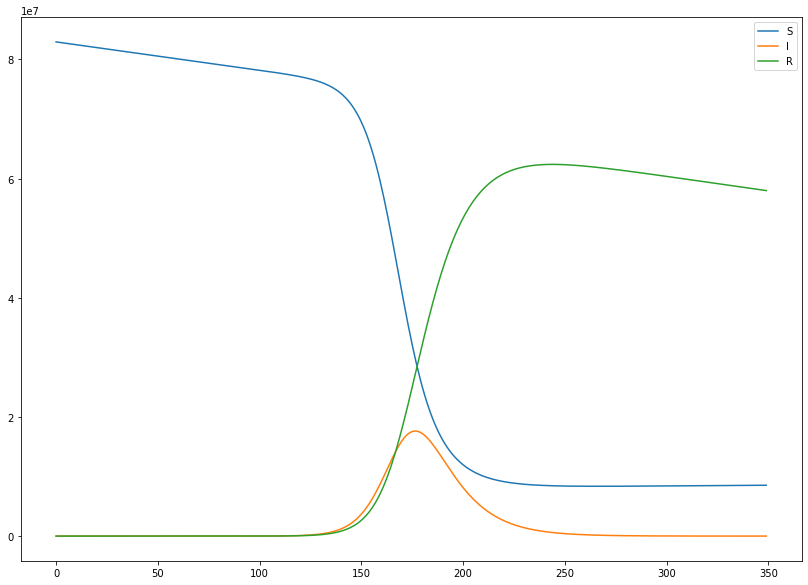

Australia


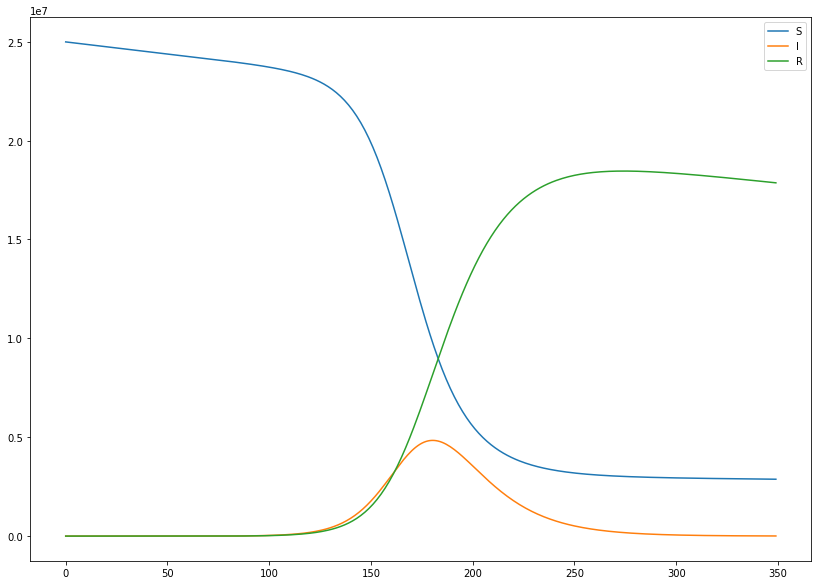

United Arab Emirates


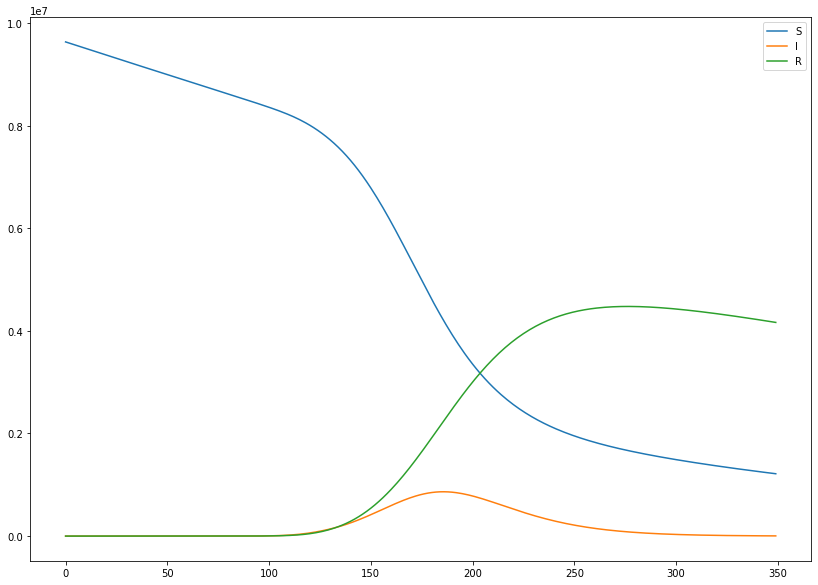

Canada


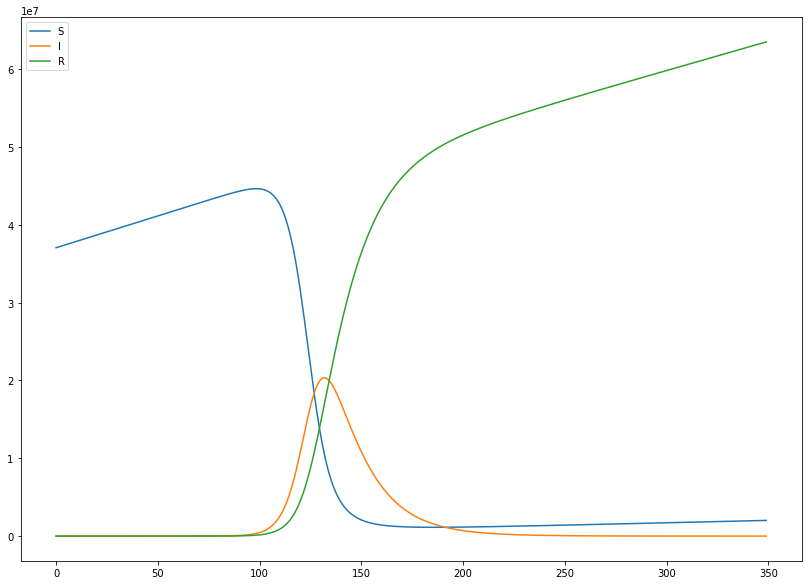

Bahrain


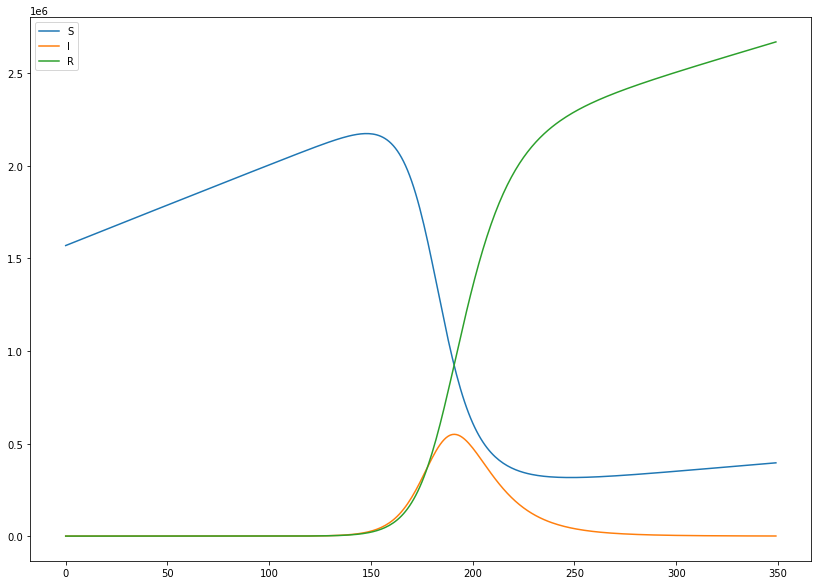

Iran


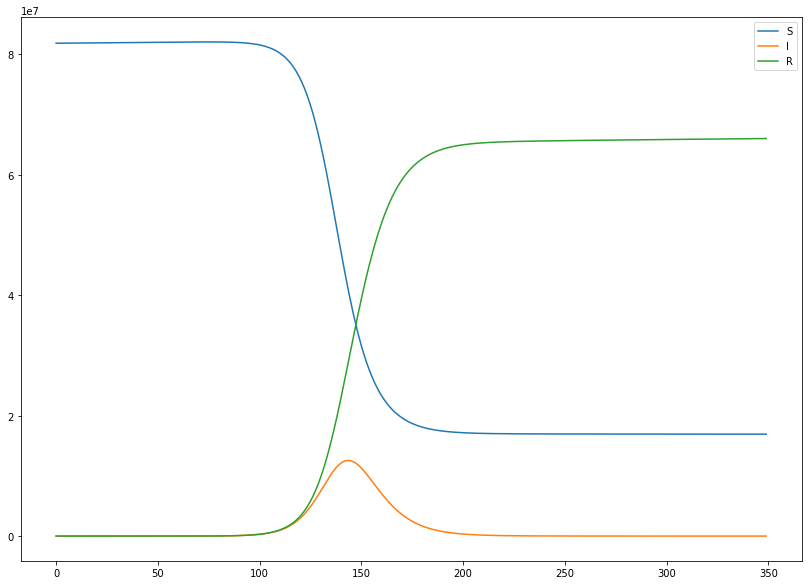

Belgium


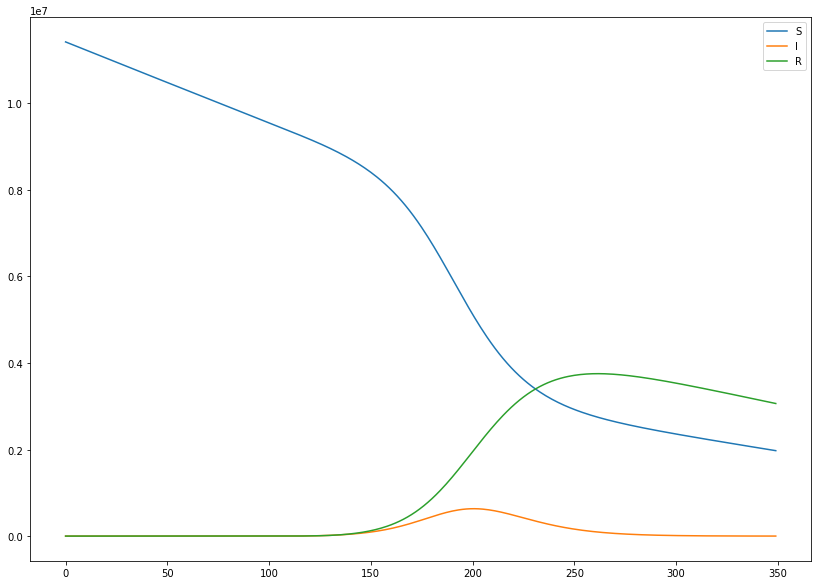

China


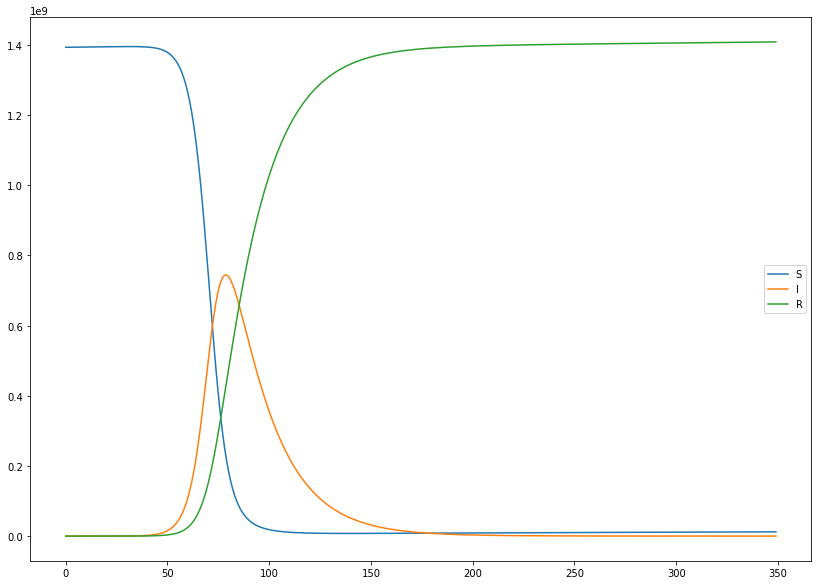

Spain


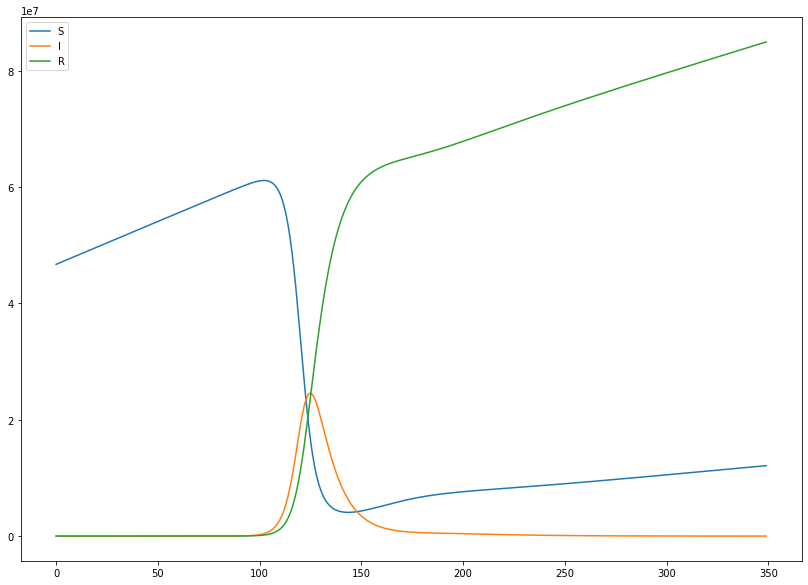

Hong Kong


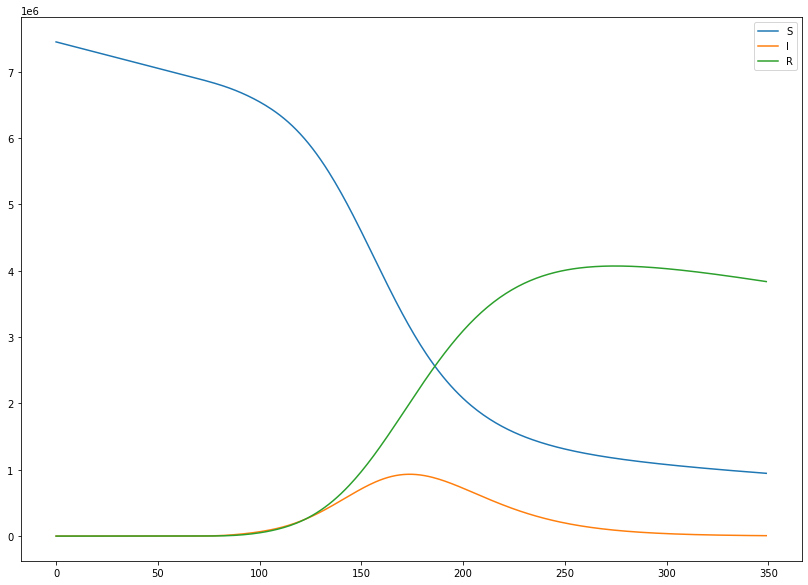

Sri Lanka


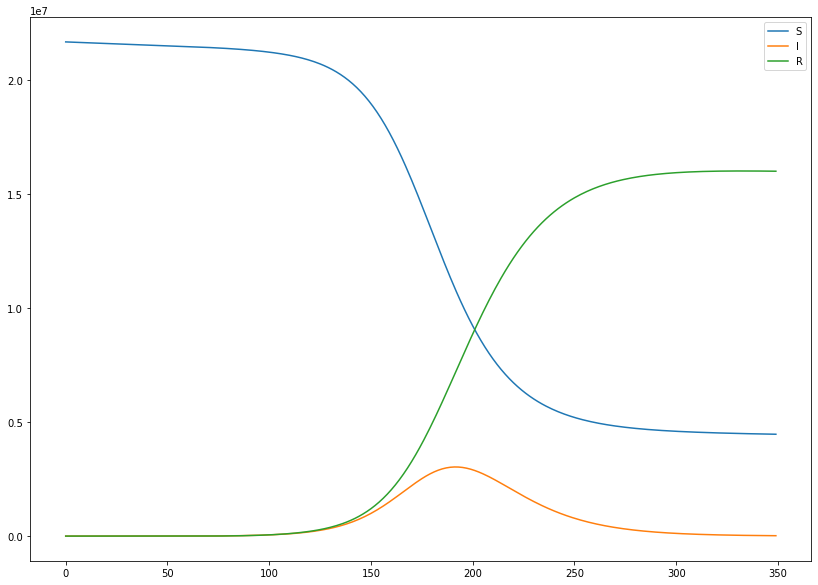

Kuwait


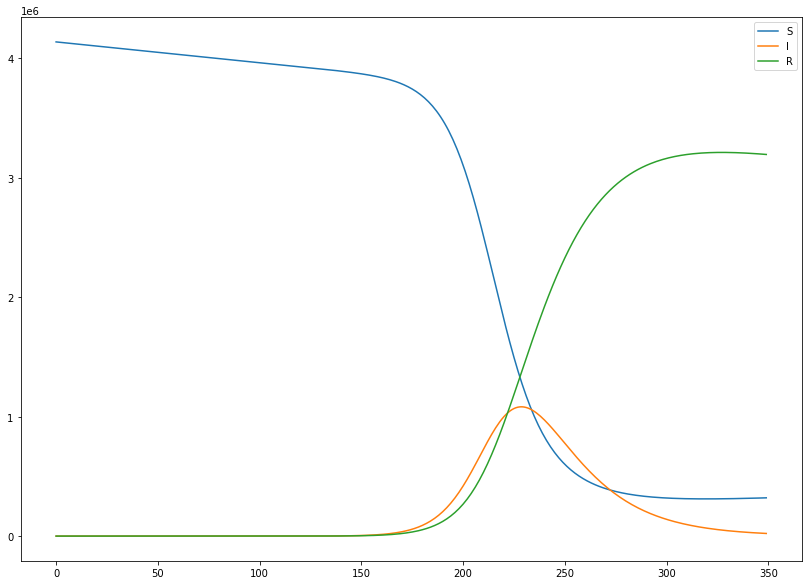

Oman


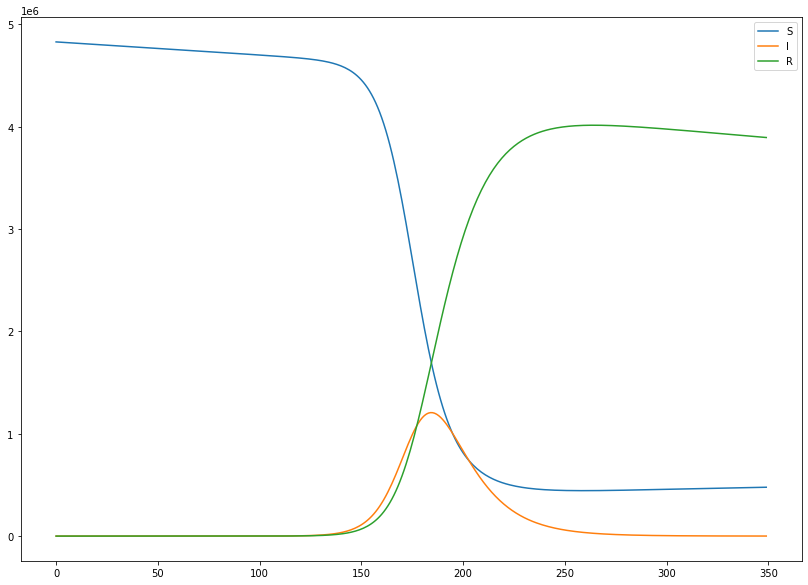

Lebanon


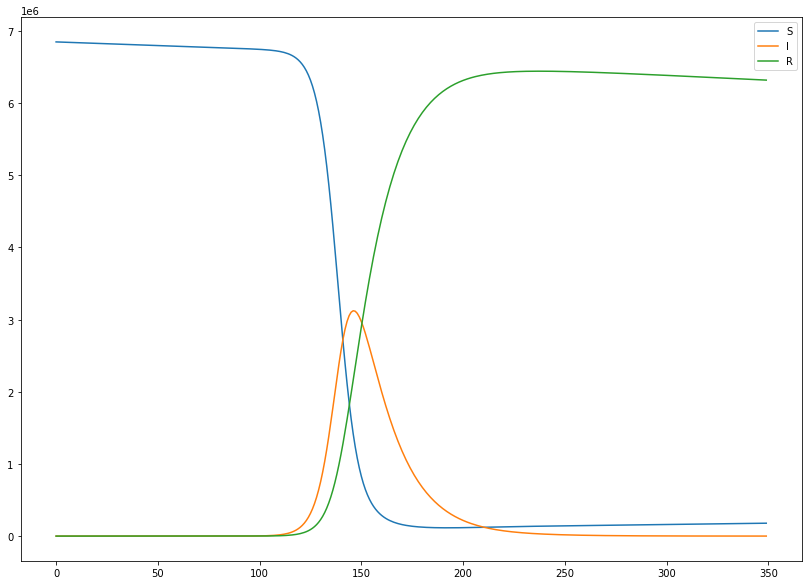

Iraq


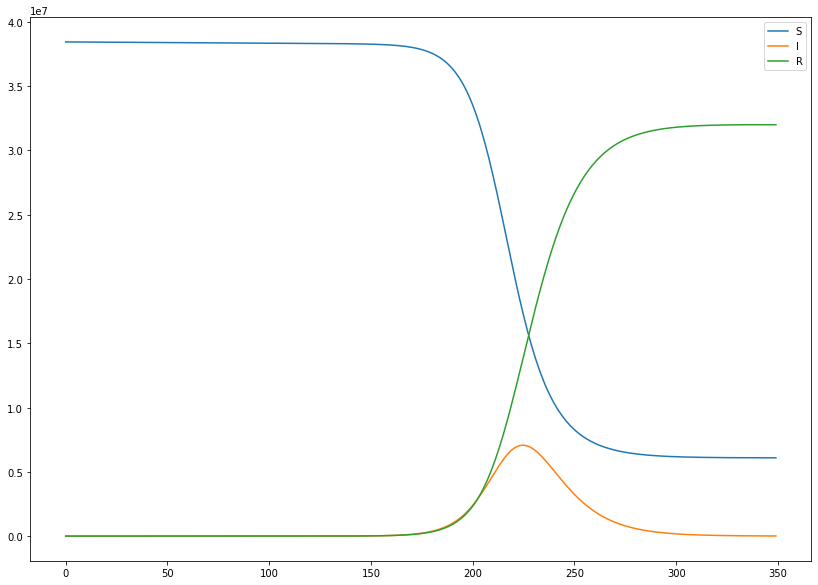

Egypt


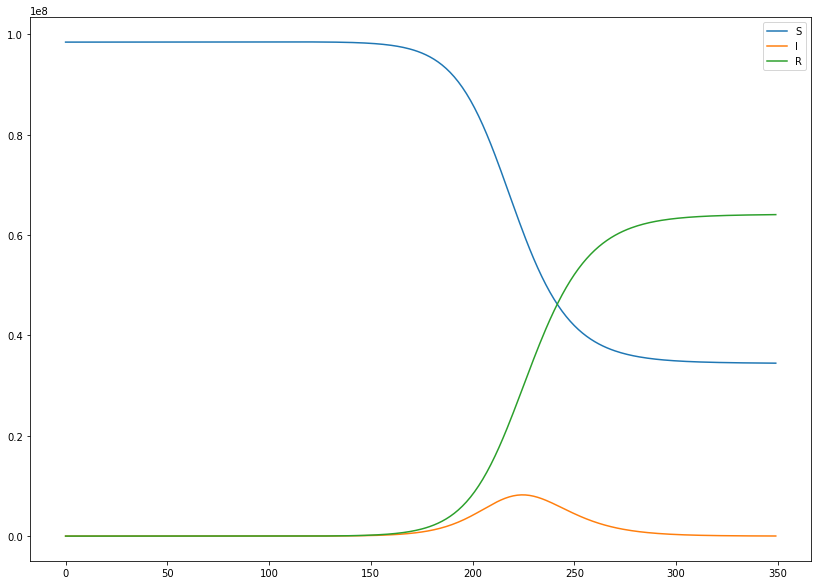

Cambodia


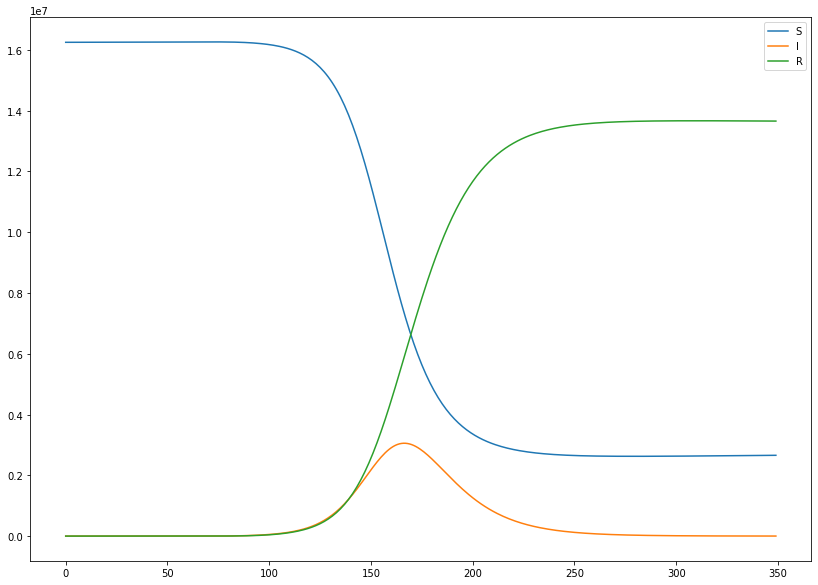

India


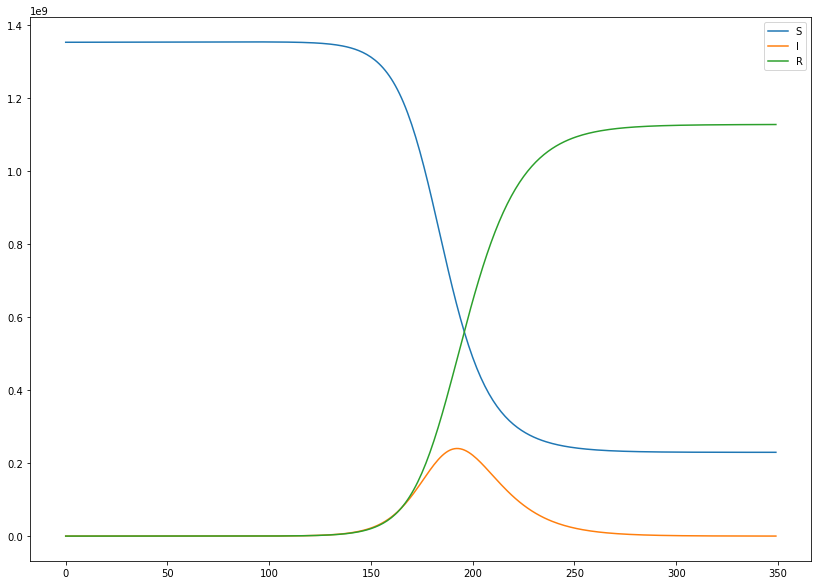

Nepal


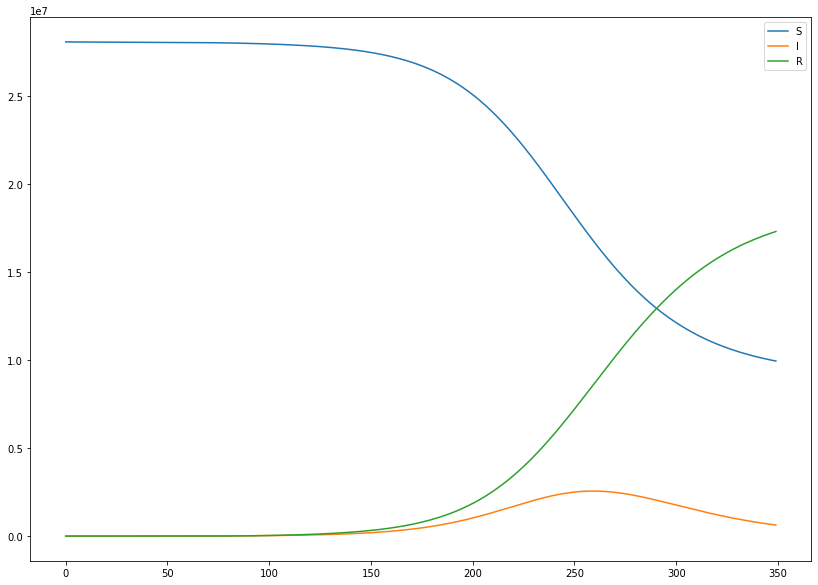

Afghanistan


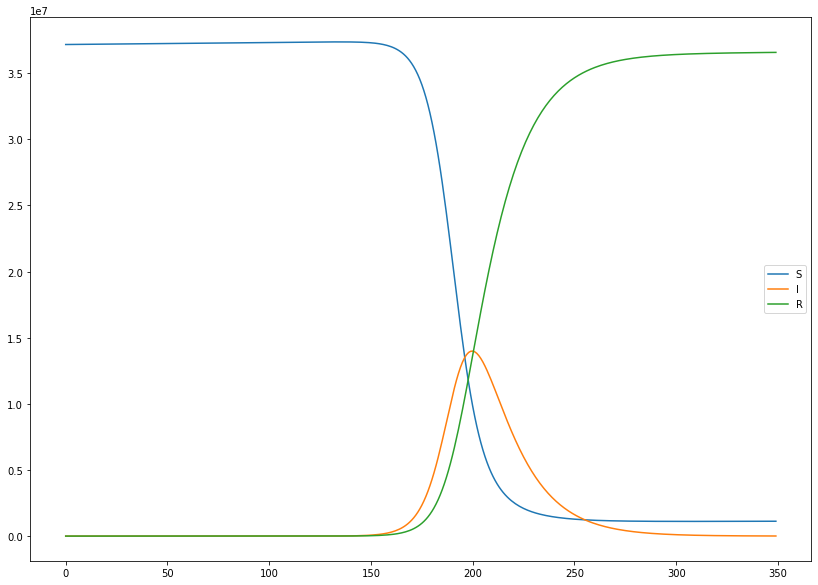

World


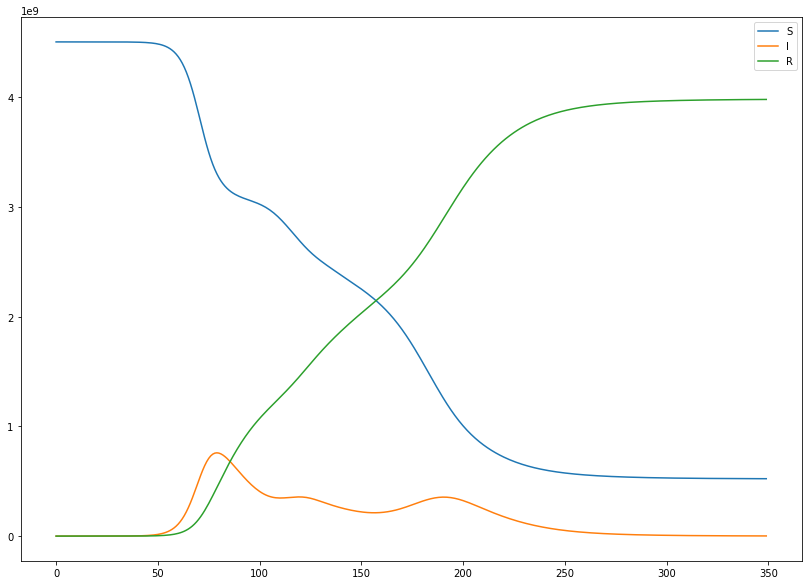

In [13]:
# Visualize simulation results
x = list(range(T))
for c in countries:
    print(c)
    plt.figure(figsize=(14,10))
    plt.plot(x, S_lists[c], label="S")
    plt.plot(x, I_lists[c], label="I")
    plt.plot(x, R_lists[c], label="R")
    plt.legend()
    plt.show()

# World total
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([S_lists[c][d] for c in countries]).sum() for d in range(T)], label="S")
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum() for d in range(T)], label="I")
plt.plot(x, [np.array([R_lists[c][d] for c in countries]).sum() for d in range(T)], label="R")
plt.legend()
plt.show()

In [401]:
# For each country which simulation day sees the pick 
countries_peak_day = {c: I_lists[c].index(max(I_lists[c])) for c in countries}
{k: v for k, v in sorted(countries_peak_day.items(), key=lambda item: item[1])}

{'China': 79,
 'South Korea': 89,
 'Macau': 96,
 'United States': 120,
 'Sweden': 123,
 'Spain': 125,
 'Israel': 128,
 'Canada': 132,
 'Japan': 139,
 'Iran': 144,
 'Russia': 146,
 'Lebanon': 146,
 'Italy': 160,
 'Cambodia': 166,
 'Singapore': 173,
 'Hong Kong': 174,
 'Taiwan': 175,
 'Germany': 177,
 'Australia': 180,
 'Finland': 182,
 'Oman': 184,
 'United Kingdom': 185,
 'United Arab Emirates': 186,
 'France': 187,
 'Malaysia': 187,
 'Philippines': 189,
 'Bahrain': 191,
 'Sri Lanka': 192,
 'India': 192,
 'Afghanistan': 200,
 'Belgium': 201,
 'Thailand': 208,
 'Vietnam': 225,
 'Iraq': 225,
 'Egypt': 225,
 'Kuwait': 229,
 'Nepal': 259}